In [1]:
!python --version

Python 3.9.19


In [2]:
# CREAMOS LOS CONJUNTOS DE ENTRENAMIENTO Y TEST
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(25)

inEnglish=True
crearNuevoConjunto=True

# Tomando 1:positivo, 0:neutro, -1:negativo
sujeto   = ['turista','estudiante','familia']
pol_suj  = [0,0,1]
verbo    = ['visita','disfruta','recomienda','entra','critica']
pol_ver  = [1,1,1,0,-1]
objeto   = ['mina','museo','fábrica','paisaje','cueva','ruta','tren']
pol_obj  = [0,0,0,0,0,0,0]
adjetivo = ['abandonado','interesante','impresionante','aburrido','desagradable','abierto']
pol_adj  = [-1,1,1,-1,-1,0]

if inEnglish:
    sujeto   = ['tourist','student','family']
    verbo    = ['visits','enjoys','recommends','enters','criticizes']
    objeto   = ['mine','museum','factory','landscape','cave','route','train']
    adjetivo = ['abandoned','interesting','impressive','boring','disgusting','open']
    
if crearNuevoConjunto:
    conjunto_entrenamiento = []
    for s in range(len(sujeto)):
        for v in range(len(verbo)):
            for o in range(len(objeto)):
                for a in range(len(adjetivo)):
                    suma = pol_suj[s]+pol_ver[v]+pol_obj[o]+pol_adj[a]
                    if suma>0.01: polaridad = 1
                    elif suma<-0.01: polaridad = -1
                    else: polaridad = 0 
                    frase = sujeto[s] + ' ' + verbo[v] + ' ' + objeto[o] + ' ' + adjetivo[a]
                    if inEnglish: frase = sujeto[s] + ' ' + verbo[v] + ' ' + adjetivo[a] + ' ' + objeto[o] 
                    conjunto_entrenamiento.append((frase, polaridad))
    
    conjunto = pd.DataFrame(conjunto_entrenamiento, columns=['frase', 'polaridad'])
    conjunto.to_csv('conjunto_individuales.csv', index=False)
    
    # seleccionamos frases positivas y negativas
    N = 100 # Numero de frases de cada tipo
    positivos = conjunto.loc[conjunto['polaridad']==1]
    negativos = conjunto.loc[conjunto['polaridad']==-1]
    
    positivos = positivos.sample(N)
    negativos = negativos.sample(N)
    todos = pd.concat([positivos,negativos])
    frases = todos.to_numpy()
    
    conjunto_nuevo = []
    while len(conjunto_nuevo)<700:
        i,j=np.random.choice(np.arange(0,2*N),size=2,replace=False).tolist()
        frase1 = frases[i][0]
        pol1 = frases[i][1]
        frase2 = frases[j][0]
        pol2 = frases[j][1]
        if np.sign(pol1)==np.sign(pol2): pol3=1
        else: pol3=0
        linea = (frase1+str(' .'),frase2+str(' .'),str(pol3))
        conjunto_nuevo.append((frase1+str(' .'),frase2+str(' .'),str(pol3)))
    
    conjunto2 = pd.DataFrame(conjunto_nuevo)
    conjunto2.to_csv('conjunto_parejas.csv', index=False,header=False)
    
    train, testsplit = train_test_split(conjunto2, test_size=400/700)
    test, dev = train_test_split(testsplit, test_size=0.5)
    
    train.to_csv('mc_pair_train_data.csv', index=False,header=False)
    test.to_csv('mc_pair_test_data.csv', index=False,header=False)
    dev.to_csv('mc_pair_dev_data.csv', index=False,header=False)

In [3]:
import torch
import random

SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            line = line.split(',')
            labels.append(int(line[2]))
            sentences.append((line[0], line[1]))
    return labels, sentences

train_labels, train_data = read_data('mc_pair_train_data.csv')
dev_labels, dev_data = read_data('mc_pair_dev_data.csv')
test_labels, test_data = read_data('mc_pair_test_data.csv')

print(list(zip(train_data[:5], train_labels[:5])))

[(('family criticizes abandoned mine .', 'tourist recommends interesting museum .'), 0), (('tourist criticizes disgusting cave .', 'student enjoys impressive train .'), 0), (('student enters disgusting cave .', 'family enjoys impressive route .'), 0), (('family criticizes disgusting mine .', 'family enjoys impressive train .'), 0), (('family visits impressive factory .', 'tourist visits interesting factory .'), 1)]


In [5]:
train_data_l, train_data_r = zip(*train_data)
train_data_unpaired = list(train_data_l) + list(train_data_r)
dev_data_l, dev_data_r = zip(*dev_data)
dev_data_unpaired = list(dev_data_l) + list(dev_data_r)
test_data_l, test_data_r = zip(*test_data)
test_data_unpaired = list(test_data_l) + list(test_data_r)

In [6]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data_unpaired)
raw_dev_diagrams = reader.sentences2diagrams(dev_data_unpaired)
raw_test_diagrams = reader.sentences2diagrams(test_data_unpaired)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


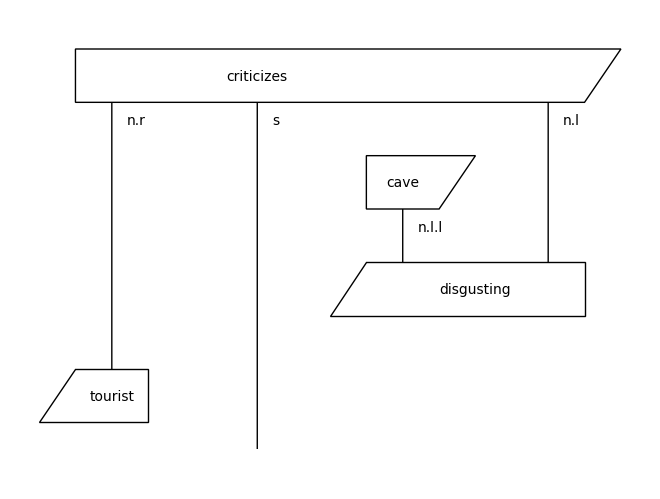

In [7]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[1].draw()

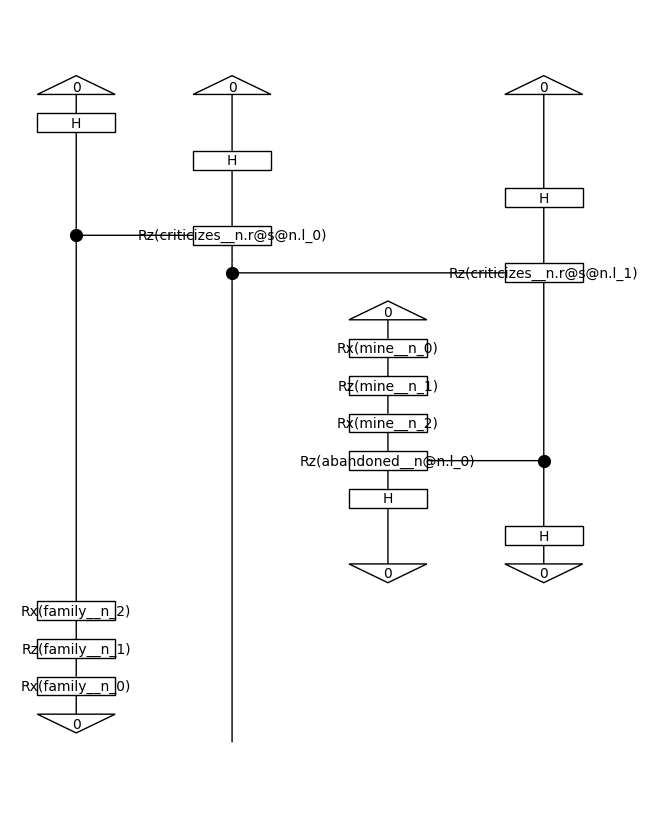

In [8]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [9]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

In [10]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        # evaluate each circuit and concatenate the results
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        # pass the concatenated results through a simple neural network
        return self.xor_net(evaluated_pairs)

In [11]:
def make_pair_data(diagrams):
    pair_diags = list(zip(diagrams[:len(diagrams)//2], diagrams[len(diagrams)//2:]))
    return pair_diags

train_pair_circuits = make_pair_data(train_circuits)
dev_pair_circuits = make_pair_data(dev_circuits)
test_pair_circuits = make_pair_data(test_circuits)

In [12]:
from lambeq import Dataset

all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model = XORSentenceModel.from_diagrams(a + b, probabilities=True, normalize=True)
model.initialise_weights()
model = model.double()

# initialise datasets and optimizers as in PyTorch
train_pair_dataset = Dataset(train_pair_circuits,
                             train_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [13]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circs)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    # evaluate on dev set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

# load the best performing iteration of the model on the dev set
if best['acc'] > accuracy(dev_pair_circuits, dev_labels):
    model.load('xor_model.lt')
    model = model.double()

print('Final test accuracy: {}'.format(accuracy(test_pair_circuits, test_labels)))

Epoch: 0
Train loss: 4.247082330627308
Dev acc: 0.54
Epoch: 5
Train loss: 4.037013063151316
Dev acc: 0.575
Epoch: 10
Train loss: 3.8854377971934695
Dev acc: 0.645
Epoch: 15
Train loss: 3.3065626111105493
Dev acc: 0.695
Epoch: 20
Train loss: 2.4809687728329526
Dev acc: 0.75
Epoch: 25
Train loss: 3.7978241338342404
Dev acc: 0.59
Epoch: 30
Train loss: 2.764651982626423
Dev acc: 0.725
Early stopping
Final test accuracy: 0.745


In [14]:
# frase positiva
frase = 'family enjoys interesting train .'
lista = [frase]

raw_frase_diagram = reader.sentences2diagrams(lista)
frase_diagram = [remove_cups(diagram) for diagram in raw_frase_diagram]
frase_circuit = [ansatz(diagram) for diagram in frase_diagram]

p_circ = frase_circuit[0].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()

print(unnorm / np.sum(unnorm))

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.99301451 0.00698549]


In [15]:
# frase negativa
frase = 'student criticizes abandoned cave .'
lista = [frase]

raw_frase_diagram = reader.sentences2diagrams(lista)
frase_diagram = [remove_cups(diagram) for diagram in raw_frase_diagram]
frase_circuit = [ansatz(diagram) for diagram in frase_diagram]

p_circ = frase_circuit[0].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()

print(unnorm / np.sum(unnorm))

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.00639521 0.99360479]


In [18]:
# frase neutra)
frase = 'student enjoys open train .'
lista = [frase]

raw_frase_diagram = reader.sentences2diagrams(lista)
frase_diagram = [remove_cups(diagram) for diagram in raw_frase_diagram]
frase_circuit = [ansatz(diagram) for diagram in frase_diagram]

p_circ = frase_circuit[0].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()

print(unnorm / np.sum(unnorm))

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.5511198 0.4488802]


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


[0.9852922 0.0147078]


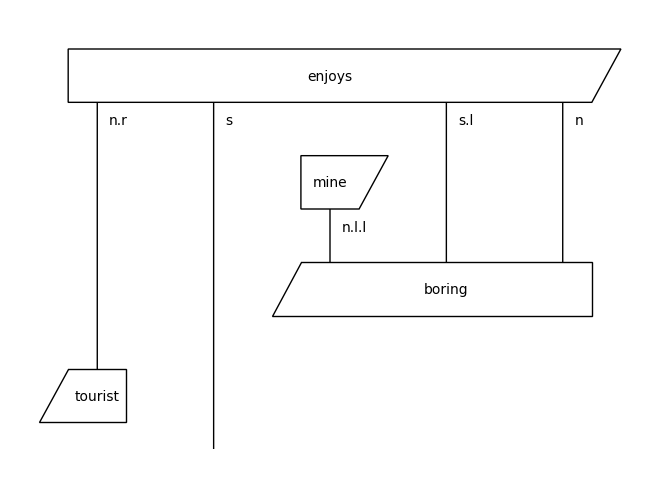

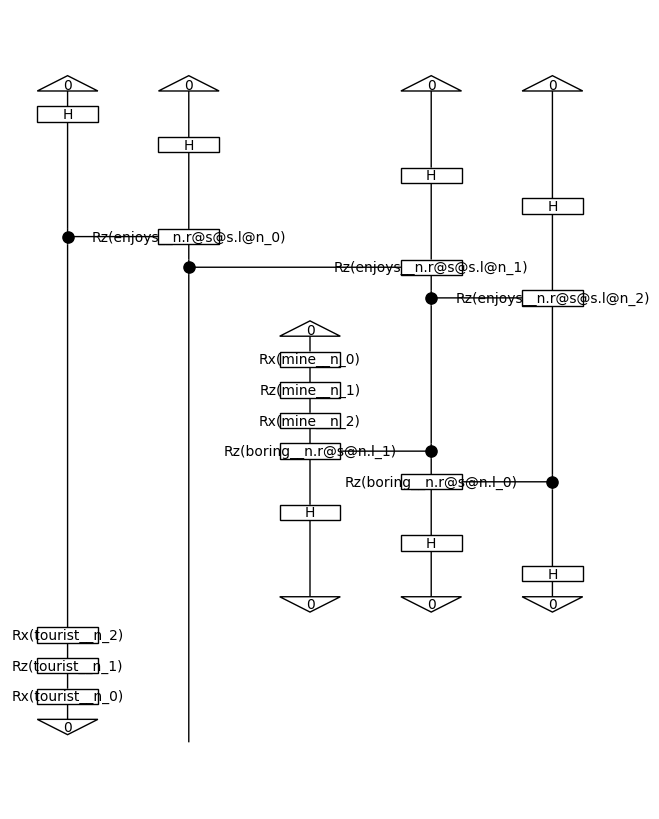

In [19]:
# frase cualquiera (muestra también el diagrama y el circuito)
frase = 'tourist enjoys boring mine .'
lista = [frase]

raw_frase_diagram = reader.sentences2diagrams(lista)
frase_diagram = [remove_cups(diagram) for diagram in raw_frase_diagram]
frase_circuit = [ansatz(diagram) for diagram in frase_diagram]

p_circ = frase_circuit[0].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()

print(unnorm / np.sum(unnorm))

frase_diagram[0].draw()
frase_circuit[0].draw(figsize=(6, 8))